<h1 align="center"><font face = "Times New Roman" size = "80">H.264 Video Compression</font></h1>
<h2 align="center"><font face = "Times New Roman" size = ""> Information theory and coding</font></h2>
<h3 align="center"><font face = "Times New Roman"> Fall 2019</font></h3>
<h5 align="center"><font face = "Times New Roman"">Alaa Mohamed Roshdy&nbsp 201600031</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Adham Mahrous&nbsp 201601078</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Mostafa Hamed&nbsp 201600236</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Kasem Saber&nbsp 201601144</font></h5>




---



In [1]:
from matplotlib import pyplot as plt
import cv2
from IPython.display import Video # To display the video in the notebook
import numpy as np

In [17]:
import julia 
import Encoder as E
import math
jl = julia.Julia()
jl.include('bac.jl')
jl.include('motion_estimation.jl')
path="mountain.mp4"
predictedPerRef=3 
no_frames = 5
Resolution=1
vid_frame=E.get_video_frames(path,no_frames,Resolution)
vid_frame=E.interlace_comp_frames(vid_frame)
ref_frames=vid_frame[::predictedPerRef]
vid_mv=[]
vid_residuals=[]
c=1
n=0
for j in range(0,math.ceil(len(vid_frame)/predictedPerRef)):

    #Reshaping the reference frames to use in the coming blocks
    im_ref_y,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][0]))
    im_ref_cb,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][1],8),8)
    im_ref_cr,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][2],8),8)


    for i in range(0,predictedPerRef-1):
        #print(ref_frames[j][0])
        #Reshaping the current frame 
        current_im_blocks, nrows, ncols = E.get_sub_images(E.reshape_image(vid_frame[c][0]))

        #Motion estimation 
        mv = jl.motion_estimation_to_all(ref_frames[j][0], current_im_blocks, nrows, ncols)
        print(j)

        #Motion Compensation
        p_image_y = E.predict(im_ref_y,mv, ref_frames[0][0].shape[0], ref_frames[0][0].shape[1],16)
        mv_cb=np.zeros(mv.shape,dtype=int)
        for x in range(mv.shape[0]):
            for z in range(mv.shape[1]):
                mv_cb[x][z][0]=np.int(mv[x][z][0]/2)
                mv_cb[x][z][1]=np.int(mv[x][z][1]/2)

        p_image_cb=E.predict(im_ref_cb,mv_cb, ref_frames[0][1].shape[0], ref_frames[0][1].shape[1],8)
        p_image_cr=E.predict(im_ref_cr,mv_cb, ref_frames[0][2].shape[0], ref_frames[0][2].shape[1],8)

        #Calculating the residuals
        residual_frame_y=E.residual(vid_frame[c][0],p_image_y)
        residual_frame_cb=E.residual(vid_frame[c][1],p_image_cb)
        residual_frame_cr=E.residual(vid_frame[c][2],p_image_cr)

        #Spatial model 
        #residual_blocks=E.spatial_model(residual_frame)



        # appending motion vectors and residual frames to change into bits
        vid_mv.append(mv)
        vid_residuals.append([residual_frame_y,residual_frame_cb,residual_frame_cr])



        c+=1
        if(c>len(vid_frame)-1):
            break
    c+=1
    if(c>len(vid_frame)-1):
        break
    n+=1

0
0
1


In [18]:
len(vid_residuals)

3

In [5]:
#del ref_frames
del residual_frame_y, residual_frame_cb, residual_frame_cr
del p_image_cb, p_image_cr

In [6]:
quantized_coeff = []
for j in range(0,predictedPerRef-1):
    quantized_coeff_y = E.spatial_model(vid_residuals[j][0], 16)
    
    quantized_coeff_cb = E.spatial_model(vid_residuals[j][1], 8)
    
    quantized_coeff_cr = E.spatial_model(vid_residuals[j][2], 8)
    
    quantized_coeff.append([quantized_coeff_y,quantized_coeff_cb,quantized_coeff_cr])
    del quantized_coeff_y, quantized_coeff_cb, quantized_coeff_cr

In [8]:
quantized_residual = []
for j in range(0,predictedPerRef-1):
    quantized_residual_y =  E.spatial_inverse_model(quantized_coeff[j][0], nrows, ncols, 16)

    quantized_residual_cb  = E.spatial_inverse_model(quantized_coeff[j][1], nrows, ncols, 8)

    quantized_residual_cr = E.spatial_inverse_model(quantized_coeff[j][2], nrows, ncols, 8) 
    
    quantized_residual.append([quantized_residual_y, quantized_residual_cb, quantized_residual_cr])
    del quantized_residual_y, quantized_residual_cb, quantized_residual_cr

In [9]:
    Reconstruced_frames=[]
    c=0
    for j in range(0,np.int(no_frames/predictedPerRef)):
        Reconstruced_frames.append(E.conv_decom_YUV2RGB(E.deinterlace_comp_frames(ref_frames[j])))

        #Reshaping the reference frames to use in the coming blocks
        im_ref_y,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][0]))
        im_ref_cb,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][1],8),8)
        im_ref_cr,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][2],8),8)
        for i in range(0,predictedPerRef-1):
            #inverse spatial
            #residual_blocks, n_rows, n_cols = E.spatial_inverse_model(vid_residuals[c])
            #residual_frame = E.get_reconstructed_image(residual_blocks, n_rows, n_cols)
            mv=vid_mv[c]
            for i in range(mv.shape[0]):
                for j in range(mv.shape[1]):
                    mv_cb[i][j][0]=np.int(mv[i][j][0]/2)
                    mv_cb[i][j][1]=np.int(mv[i][j][1]/2)
            #getting the predicted image
            p_image_y=E.predict(im_ref_y,mv, ref_frames[0][0].shape[0], ref_frames[0][0].shape[1])
            p_image_cb=E.predict(im_ref_cb,mv_cb, ref_frames[0][1].shape[0], ref_frames[0][1].shape[1],8)
            p_image_cr=E.predict(im_ref_cr,mv_cb, ref_frames[0][2].shape[0], ref_frames[0][2].shape[1],8)
            #adding the residuals to get the reconstructed image
            
            Reconstructed_y=p_image_y+quantized_residual[c][0]
            Reconstructed_cb=p_image_cb+quantized_residual[c][1]
            Reconstructed_cr=p_image_cr+quantized_residual[c][2]

            Reconstructed_interlaced=[Reconstructed_y,Reconstructed_cb,Reconstructed_cr]
            Reconstruced_frames.append(E.conv_decom_YUV2RGB(E.deinterlace_comp_frames(Reconstructed_interlaced)))
            c+=1

Text(0.5, 1.0, 'last predicted frame')

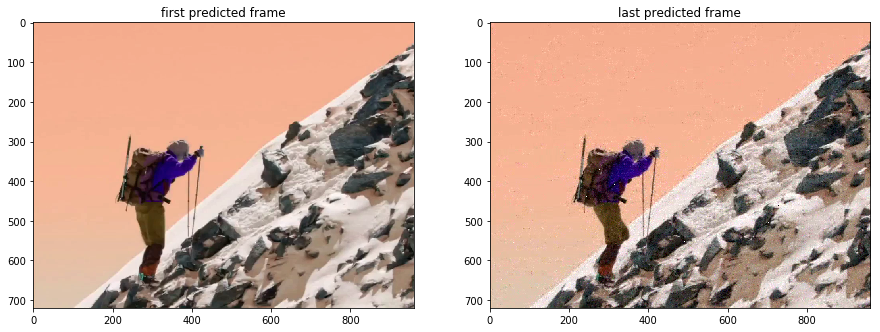

In [12]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (15,15))

ax1.imshow(Reconstruced_frames[0])
ax1.set_title("first predicted frame")


ax2.imshow(Reconstruced_frames[3])
ax2.set_title("last predicted frame")

In [52]:
Reconstruced_frames[0].shape

(720, 960, 3)

In [26]:
cv2.imshow('image',Reconstruced_frames[2])
cv2.waitKey(0)

cv2.destroyAllWindows()